# Deep Learning Project
## Baktash Ansari
## Navid Ebrahimi

Import Dataset (We use dataset of this link:)
https://mcrlab.net/research/mvsa-sentiment-analysis-on-multi-view-social-data/

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 6.0 MB/s eta 0:00:00


In [ ]:
%cd /content/drive/MyDrive/Deep/MultiModal

/content/drive/MyDrive/Deep/MultiModal


In [ ]:
!unzip ./MVSA-Single.zip

Streaming output truncated to the last 5000 lines.
 extracting: MVSA_Single/data/3347.txt  
  inflating: MVSA_Single/data/3348.jpg  
  inflating: MVSA_Single/data/3348.txt  
  inflating: MVSA_Single/data/3349.jpg  
 extracting: MVSA_Single/data/3349.txt  
  inflating: MVSA_Single/data/335.jpg  
  inflating: MVSA_Single/data/335.txt  
  inflating: MVSA_Single/data/3350.jpg  
 extracting: MVSA_Single/data/3350.txt  
  inflating: MVSA_Single/data/3351.jpg  
  inflating: MVSA_Single/data/3351.txt  
  inflating: MVSA_Single/data/3352.jpg  
  inflating: MVSA_Single/data/3352.txt  
  inflating: MVSA_Single/data/3353.jpg  
 extracting: MVSA_Single/data/3353.txt  
  inflating: MVSA_Single/data/3354.jpg  
  inflating: MVSA_Single/data/3354.txt  
  inflating: MVSA_Single/data/3355.jpg  
 extracting: MVSA_Single/data/3355.txt  
  inflating: MVSA_Single/data/3356.jpg  
  inflating: MVSA_Single/data/3356.txt  
  inflating: MVSA_Single/data/3357.jpg  
  inflating: MVSA_Single/data/3357.txt  
  inflat

## Import Dataframe

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("./MVSA_Single/labelResultAll.txt", sep="\t")
df

,ID,"text,image"
0,1,"neutral,positive"
1,2,"neutral,positive"
2,3,"neutral,positive"
3,4,"positive,positive"
4,5,"positive,positive"
...,...,...
4864,5125,"neutral,positive"
4865,5126,"positive,neutral"
4866,5127,"positive,positive"
4867,5128,"neutral,positive"


In [ ]:
df = df.rename(columns={'text,image': 'label'}).sample(500).reset_index(drop=True)

In [ ]:
df

,ID,label
0,1726,"neutral,positive"
1,3711,"neutral,positive"
2,929,"negative,negative"
3,311,"positive,positive"
4,4282,"neutral,negative"
...,...,...
495,2435,"neutral,neutral"
496,134,"neutral,negative"
497,1567,"positive,positive"
498,983,"positive,positive"


In [ ]:
#Change pair labels to single label:
count = 0
for index, row in df.iterrows():
    labels = row['label'].split(',')
    if labels.count('positive') == 1 and labels.count('negative') == 1 :
      df.at[index, 'label'] = 'neutral'
    elif labels.count('positive') == 1 and labels.count('neutral') == 1 :
      df.at[index, 'label'] = 'positive'
    elif labels.count('negative') == 1 and labels.count('neutral') == 1 :
      df.at[index, 'label'] = 'negative'
    elif labels.count('neutral') == 2:
      df.at[index, 'label'] = 'neutral'
    elif labels.count('positive') == 2:
      df.at[index, 'label'] = 'positive'
    elif labels.count('negative') == 2:
      df.at[index, 'label'] = 'negative'
    else:
      print("Error")

In [ ]:
counts = df['label'].value_counts()

print(counts)

positive    250
negative    147
neutral     103
Name: label, dtype: int64


Label :  negative
RT @Telegraph: Bewildered Greeks left wondering what happened to referendum 'No' vote 



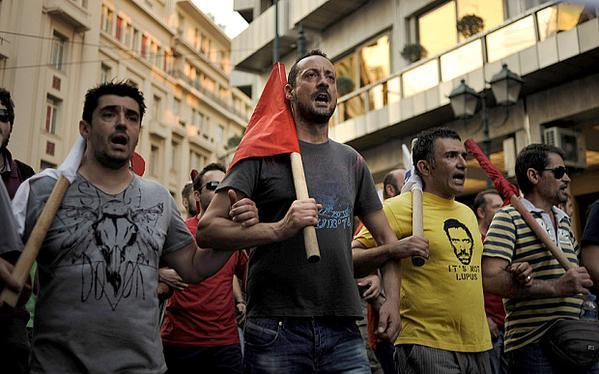

In [ ]:
from PIL import Image
row = df.loc[71]
print("Label : ", row['label'])
img = Image.open(f'./MVSA_Single/data/{row["ID"]}.jpg')
with open(f'./MVSA_Single/data/{row["ID"]}.txt', 'r', encoding='unicode_escape') as file:
  content = file.read()
print(content)
img

# Prepare train and eval dataset

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn

class MVSA_Dataset(Dataset):
    def __init__(self, dataframe, bertTokenizer, resnet, bert, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.bertTokenizer = bertTokenizer

        self.resnet = resnet
        self.bert = bert

    def text_to_vector(self, text):
      # Tokenize the text
      inputs = self.bertTokenizer(text, return_tensors='pt')

      # Get the embeddings
      outputs = self.bert(**inputs)

      # The feature vector is the mean of the last hidden state
      feature_vector = outputs.last_hidden_state.mean(dim=1)

      return feature_vector

    def image_to_vector(self, image):


      # Add an extra dimension for the batch size
      image = image.unsqueeze(0)

      # Get the visual embeddings of the image
      with torch.no_grad():
          visual_embeds = self.resnet(image)

      return visual_embeds



    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

      row = self.dataframe.iloc[idx]
      image_path = f'./MVSA_Single/data/{row["ID"]}.jpg'
      text_path = f'./MVSA_Single/data/{row["ID"]}.txt'

      # Load image
      image = Image.open(image_path)
      raw_image = image

      if self.transform:
          image = self.transform(image)

      #extract image feature
      imageVector = self.image_to_vector(image)

      # Load text
      with open(text_path, 'r', encoding='unicode_escape') as file:
          text = file.read()
      raw_text = text

      #extract text feature
      textVector = self.text_to_vector(text)

      # concat both feature vectors
      featureVector = torch.cat((imageVector.squeeze(), textVector.squeeze()))
      featureVector = featureVector.tolist()

      # Get label
      label_map = {'neutral': 0, 'positive': 1, 'negative': 2}
      label = label_map[row['label']]

      # output with the shape of 2816
      return {"featureVector" : featureVector, "label" : label, 'ID' : row["ID"]}




In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
import torchvision.models as models
from transformers import AutoTokenizer, AutoModel
import torch

# Load the pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove the last layer
resnet.eval()  # Set the model to evaluation mode

# Initialize the tokenizer and the model
bertTokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = AutoModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in a

In [ ]:
train_dataset = MVSA_Dataset(train_df, bertTokenizer, resnet, bert, transform=transform)
val_dataset = MVSA_Dataset(val_df, bertTokenizer, resnet, bert, transform=transform)

In [ ]:
finalTrain = []
finalTest = []

In [ ]:
for i in range(len(train_dataset)):
  finalTrain.append(train_dataset[i])
  print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [ ]:
for i in range(len(val_dataset)):
  finalTest.append(val_dataset[i])
  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
# save them
%cd /content/drive/MyDrive/Deep/MultiModal

finalTrainDf = pd.DataFrame(finalTrain)
finalTrainDf.to_csv('./finalTrain.csv')

finalTestDf = pd.DataFrame(finalTest)
finalTestDf.to_csv('./finalTest.csv')

/content/drive/MyDrive/Deep/MultiModal


In [ ]:
finalTestDf

,featureVector,label,ID
0,"[0.03702496364712715, 0.3313433527946472, 0.20...",2,3420
1,"[0.5426241159439087, 2.966571807861328, 0.2761...",1,3324
2,"[0.35527506470680237, 1.6832022666931152, 1.14...",1,233
3,"[1.949249267578125, 0.5469563603401184, 0.4583...",0,1871
4,"[0.11149799823760986, 0.33232077956199646, 0.2...",1,2997
...,...,...,...
95,"[0.44580259919166565, 0.05268778279423714, 0.0...",0,4698
96,"[0.16658198833465576, 0.5293667316436768, 0.05...",1,3995
97,"[0.3152162432670593, 0.37721964716911316, 0.07...",2,452
98,"[0.31570446491241455, 0.4259597659111023, 0.04...",2,4001


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn

class Final_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

      row = self.dataframe.iloc[idx]


      # output with the shape of 2816
      return {"featureVector" : row['featureVector'], "label" : row['label'], 'ID' : row['ID']}



In [ ]:
# load them
import pandas as pd
%cd /content/drive/MyDrive/Deep/MultiModal

finalTrainDf = pd.read_csv('./finalTrain.csv')
finalTestDf = pd.read_csv('./finalTest.csv')

/content/drive/MyDrive/Deep/MultiModal


In [ ]:
finalTrainDataset = Final_Dataset(finalTrainDf)
finalTestDataset = Final_Dataset(finalTestDf)

In [ ]:
finalTrainDataset[0]['featureVector']

2816

In [ ]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 512),
            nn.Sigmoid(),
            nn.Linear(512, 256),
            nn.Sigmoid(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.metrics import accuracy_score

input_size = 2816  # size of the combined feature vector
num_classes = 3
model = MLP(input_size, num_classes).to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 1e-5)

# Define the data loaders
train_loader = DataLoader(finalTrainDataset, batch_size=32, shuffle=True)
val_loader = DataLoader(finalTestDataset, batch_size=32, shuffle=False)

# Training loop
for epoch in range(5):  # adjust the number of epochs
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        feature_vector = torch.stack(batch["featureVector"]).view(-1, input_size).to(device)
        label = batch["label"].to(device)

        # Forward pass
        outputs = model(feature_vector.float())
        loss = criterion(outputs, label)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Evaluation
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            feature_vector = torch.stack(batch["featureVector"]).view(-1, input_size).to(device)
            label = batch["label"].to(device)

            outputs = model(feature_vector.float())
            loss = criterion(outputs, label)

            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.tolist())
            val_labels.extend(label.tolist())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}/{5}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Validation: 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]


Epoch 1/5, Train Loss: 1.1110, Val Loss: 1.1087, Val Accuracy: 0.2200


Validation: 100%|██████████| 4/4 [00:00<00:00, 17.84it/s]


Epoch 2/5, Train Loss: 1.1039, Val Loss: 1.1017, Val Accuracy: 0.2200


Validation: 100%|██████████| 4/4 [00:00<00:00, 10.55it/s]


Epoch 3/5, Train Loss: 1.0979, Val Loss: 1.0950, Val Accuracy: 0.5000


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epoch 4/5, Train Loss: 1.0923, Val Loss: 1.0893, Val Accuracy: 0.5000


Validation: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]

Epoch 5/5, Train Loss: 1.0872, Val Loss: 1.0840, Val Accuracy: 0.5000


# Test model

Label :  positive
Nothin but the pastel sky hangin over you and I #theOriginalGradient #cottoncandy #sky #bright #happiness 



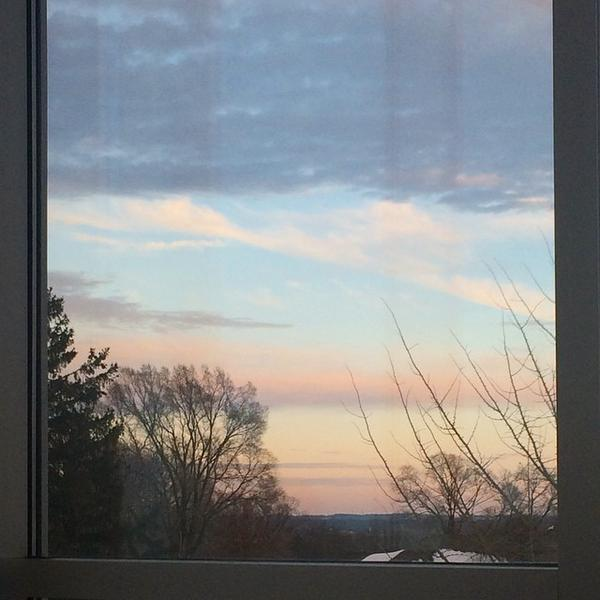

In [ ]:
sample = finalTestDataset[16]
ID = sample['ID']

label_map = {0 : 'neutral', 1 : 'positive', 2 : 'negative'}

print("Label : ", label_map[sample['label']])
img = Image.open(f'./MVSA_Single/data/{sample["ID"]}.jpg')
with open(f'./MVSA_Single/data/{sample["ID"]}.txt', 'r', encoding='unicode_escape') as file:
  content = file.read()
print(content)
img

In [ ]:
model.eval()
feature_vector = torch.tensor(sample["featureVector"]).view(-1, input_size).to(device)
output = model(feature_vector.float())
pred = output.argmax(dim=1).tolist()
label_map[pred[0]]

'positive'